<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PAC3</p>
<p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación
</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos cómo los diferentes modelos clasifican los puntos y con cuáles obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un conjunto de datos nuevo simulando un caso práctico real.

1. Exploración de algoritmos supervisados
       1.2. K vecinos más cercanos
       1.3. Support vector machines
       1.4. Árbol de decisión
       1.5. Random forest
       1.5. Gradient boosting
2. Implementación de un caso práctico
       2.1. Análisis descriptivo
       2.2. Preprocesamiento de los datos
       2.3. Entrenamiento de un modeo
       2.4. Predicción de casos nuevos

**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega se ha de hacer en formato notebook y en formato html, donde se vea el código y los resultados junto con los comentarios de cada ejercicio. Para exportar el notebook a html se puede hacer desde el menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Francisco Javier Morales Hidalgo</strong>
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

%matplotlib inline

## 1. Carga de datos

El conjunto de datos MOONS consiste en puntos en un plano que forman dos lunas, de ahí el nombre de "moons". Cada luna se corresponde a un grupo diferente [0, 1].

El siguiente código generará 1.000 puntos y hará un gráfico para visualizar las dos lunas con colores diferentes para cada grupo.

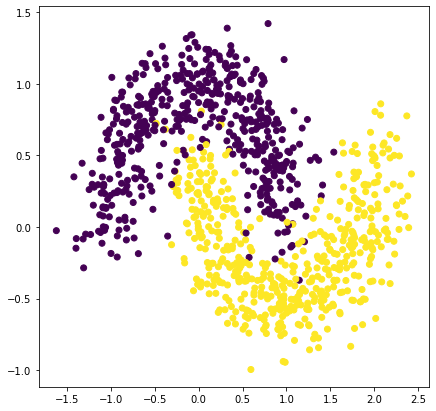

In [2]:
df = make_moons(n_samples=1000, noise=0.2, random_state=2)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group)

Antes de aplicar ningún modelo, hemos de separar los datos entre el conjunto de *train* y el conjunto de *test*. Siempre trabajaremos sobre el conjunto de *train* y evaluaremos los resultados en *test*.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> divide el <i>dataset</i> en dos subconjuntos, <i>train</i> (80% aprox.) y <i>test</i>. Puedes servirte de <i>train_test_split</i>, ya implementado en <i>sklearn</i>.
</div>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], train_size=0.8, random_state=42)

A lo largo de los ejercicios veremos gráficamente las fronteras de decisión asociadas a cada uno de los diferentes modelos. Para hacerlo utilizaremos la función definida a continuación. Dicha función sigue los siguientes pasos:

- Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) con los valores mínimos y máximos de 'x' e 'y'.
- Predecir con el clasificador los valores de la *meshgrid*.
- Hacer un *reshape* de los datos para tener el formato correspondiente.

Una vez hecho esto, ya podemos crear el gráfico de las fronteras de decisión y añadirle los puntos reales.
Así, veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. De esta forma, comprobaremos si el modelo clasifica los puntos correctamente dentro del área que les corresponde. También detectaremos las áreas de incertidumbre, casos en los que el modelo no se decanta ni por una clase ni por la otra (o si sí que se decanta por una pero no lo tiene 100% claro), éstas áreas serán blanquecinas.

In [4]:
# Hacemos la meshgrid con los valores máximos y mínimos de 'x' e 'y'.
x_min, x_max = min(df_x)-0.1, max(df_x)+0.1
y_min, y_max = min(df_y)-0.1, max(df_y)+0.1

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Predecimos los valores de la meshgrid con el clasificador.
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Hacemos el reshape para tener el formato correcto.
    Z = Z.reshape(xx.shape)

    # Seleccionamos una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Creamos el gráfico con las fronteras de decisión.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Añadimos los puntos.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

### 1.1 $K$ vecinos más cercanos (1 punto)

El primer algoritmo que utilizaremos para clasificar los puntos es el $k$-nn. En este ejercicio, ajustaremos dos hiperparámetros del algoritmo con la intención de obtener una mayor precisión:

- $k$: el número de vecinos que se considera para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.
- pesos: importancia que se da a cada uno de los vecinos considerados. En este caso, jugaremos con dos opciones: pesos uniformes, donde todos los vecinos se consideran de igual manera; y pesos en función de la distancia, donde los vecinos más cercanos tienen más peso en la clasificación que los vecinos más lejanos.

Para decidir cuáles son los hiperparámetros óptimos utilizaremos la técnica de búsqueda conocida como *grid search*, con la que entrenaremos un modelo para cada combinación de hiperparámetros posible y la evaluaremos utilizando validación cruzada (*cross validation*) con 4 particiones estratificadas. Posteriormente, elegiremos la combinación de hiperparámetres que mejores resultados haya obtenido.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>k</i> y <i>pesos</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y KNeighborsClassifier de sklearn.
</div>

In [5]:
param_grid = {'n_neighbors': np.arange(1, 11, 1),
              'weights': ['uniform', 'distance']}

gs = GridSearchCV(KNeighborsClassifier(), param_grid,cv=4)

gs_results = gs.fit(X_train, y_train)

Best cross-validation score: 0.97
Best parameters:  {'n_neighbors': 3, 'weights': 'uniform'}


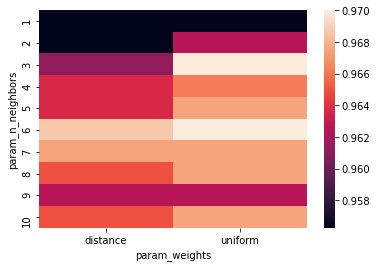

In [6]:
print("Best cross-validation score: {:.2f}".format(gs_results.best_score_))
print("Best parameters: ", gs_results.best_params_)

import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='mean_test_score', index='param_n_neighbors', columns='param_weights')

pvt
ax = sns.heatmap(pvt)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

In [7]:
knn = KNeighborsClassifier(n_neighbors=gs_results.best_params_["n_neighbors"], weights=gs_results.best_params_["weights"])
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

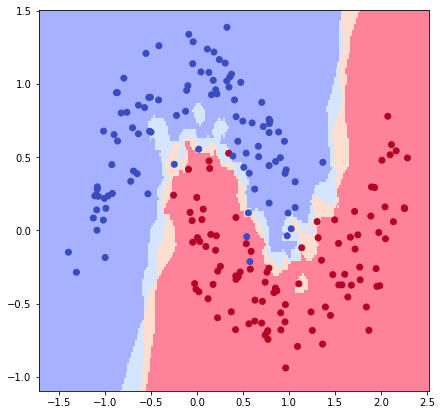

In [8]:
plot_decision_boundaries(X_test[:,0],X_test[:,1],y_test,knn)

In [9]:
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(acc))

Accuracy: 0.96


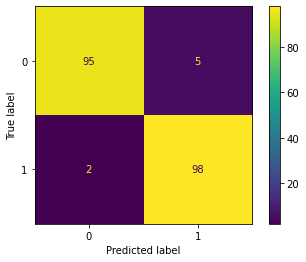

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

Podemos ver tanto gráficamente, como por la tabla de confusión como por la accuracy, que el modelo predice bastante bien a qué luna pertenece cada punto nuevo. El problema que se aprecia es que las aréas grises donde el modelo no termina de decantarse por una luna es irregular, en algunas ocasiones demasiado grande y podemos encontrarlas en algunos casos alejadas del borde.

### 1.2. Support Vector Machines (1 punto)

En este segundo ejercicio, clasificaremos los puntos utilizando el algoritmo SVM con el *kernel* radial. Volveremos a utilizar *grid search*. En este caso los hiperparámetros a optimizar son:

- C: regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
- gamma: coeficiente que multiplica la distancia entre dos puntos al kernel radial. A "grosso modo", cuanto más pequeña es gamma, más influencia tienen los puntos cercanos. Probaremo los valores: 0.001, 0.01, 0.1, 1 y 10.

Igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>C</i> y <i>gamma</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y SVC de sklearn.
</div>

In [11]:
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100, 200],
              'gamma': [0.001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(svm.SVC(probability=True), param_grid,cv=4)

gs_results = gs.fit(X_train, y_train)

Best cross-validation score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


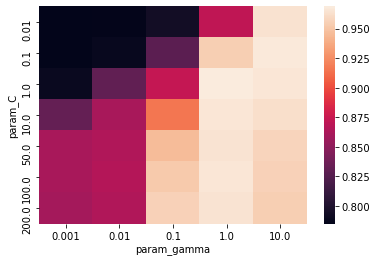

In [12]:
print("Best cross-validation score: {:.2f}".format(gs_results.best_score_))
print("Best parameters: ", gs_results.best_params_)

import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='mean_test_score', index='param_C', columns='param_gamma')

pvt
ax = sns.heatmap(pvt)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

In [13]:
svn_model = svm.SVC(C=gs_results.best_params_["C"], gamma=gs_results.best_params_["gamma"], probability=True)
svn_model.fit(X_train,y_train)

SVC(C=1, gamma=1, probability=True)

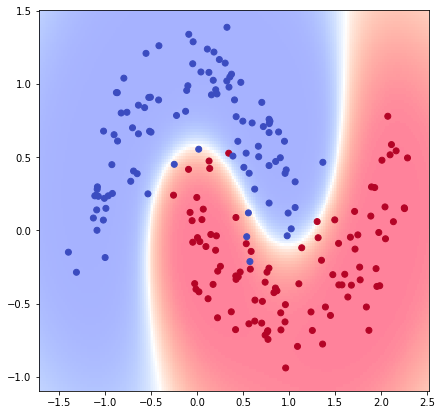

In [14]:
plot_decision_boundaries(X_test[:,0],X_test[:,1],y_test,svn_model)

In [15]:
y_pred = svn_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(acc))

Accuracy: 0.96


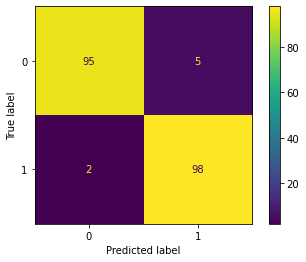

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

Los resultados del modelos son muy similares al anterior en cuestión de accuracy y matriz de confusión. Donde puede verse una mejora es a la hora de pintar las zonas y el borde. Siendo este claramente dibujado y puede verse como a medida que nos alejamos de él, el modelo se decanta más por una zona u otra.

### 1.3. Árboles de decisión (1 punto)

En este tercer ejercicio, clasificaremos los puntos utilizando un árbol de decisión. Utilizaremos como antes *grid search* para ajustar los hiperparámetros. En este caso ajustaremos los siguientes:

- max_depth: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10. 
- min_samples_split: el mínimo número de observaciones que ha de tener una hoja del árbol para poderse dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>max_depth</i> y <i>min_samples_split</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y DecisionTreeClassifier de sklearn.
</div>

In [17]:
param_grid = {'max_depth': np.arange(4, 11, 1),
              'min_samples_split': [2,10, 20, 50, 100]}

gs = GridSearchCV(DecisionTreeClassifier(), param_grid,cv=4)

gs_results = gs.fit(X_train, y_train)

Best cross-validation score: 0.95
Best parameters:  {'max_depth': 8, 'min_samples_split': 2}


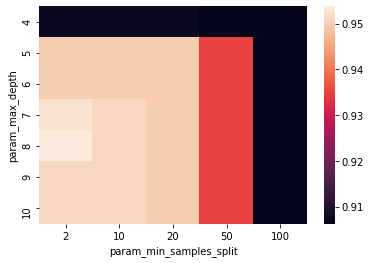

In [18]:
print("Best cross-validation score: {:.2f}".format(gs_results.best_score_))
print("Best parameters: ", gs_results.best_params_)

import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')

pvt
ax = sns.heatmap(pvt)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

In [19]:
dtc_model = DecisionTreeClassifier(max_depth=gs_results.best_params_["max_depth"], min_samples_split=gs_results.best_params_["min_samples_split"])
dtc_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8)

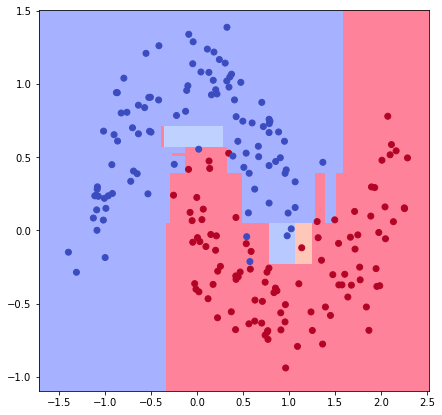

In [20]:
plot_decision_boundaries(X_test[:,0],X_test[:,1],y_test,dtc_model)

In [21]:
y_pred = dtc_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(acc))

Accuracy: 0.96


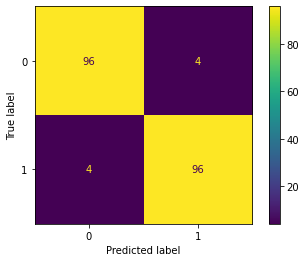

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

Los resultado son similares al resto. Respecto a la frontera, considero que no es muy buena. No sólamente porque no esté tan "suavemente" delimitada como la del SVN, ni porque encontramos zonas aisladas y alejadas de la propia frontera, sino porque no tenemos zonas grises. O pertenece a una luna o pertenece a otra.

### 1.4. Random forest (1 punto)

En este cuarto ejercicio, clasificaremos los puntos utilizando Random forest. Utilizaremos, como hasta ahora, *grid search* para ajustar los hiperparámetros y ajustaremos:

- max_depth: la profundidad máxima del árbol. Exploraremos los valores comprendidos entre 6 y 12. 
- n_estimators: número de árboles. Exploraremos los valores: 10, 50, 100 y 200.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>max_depth</i> y <i>n_estimators</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y RandomForestClassifier de sklearn.
</div>

In [23]:
param_grid = {'max_depth': np.arange(6, 13, 1),
              'n_estimators': [10, 50, 100, 200]}

gs = GridSearchCV(RandomForestClassifier(), param_grid,cv=4)

gs_results = gs.fit(X_train, y_train)

Best cross-validation score: 0.96
Best parameters:  {'max_depth': 12, 'n_estimators': 10}


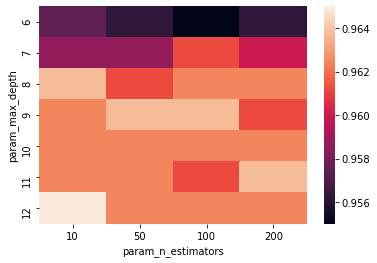

In [24]:
print("Best cross-validation score: {:.2f}".format(gs_results.best_score_))
print("Best parameters: ", gs_results.best_params_)

import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')

pvt
ax = sns.heatmap(pvt)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

In [25]:
rfc_model = RandomForestClassifier(max_depth=gs_results.best_params_["max_depth"], n_estimators=gs_results.best_params_["n_estimators"])
rfc_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=12, n_estimators=10)

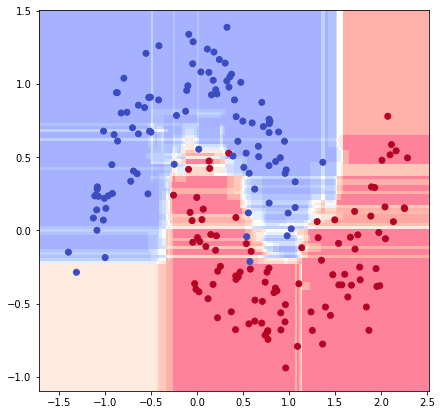

In [26]:
plot_decision_boundaries(X_test[:,0],X_test[:,1],y_test,rfc_model)

In [27]:
y_pred = rfc_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(acc))

Accuracy: 0.96


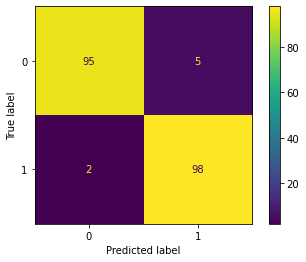

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>


Los resultados tanto de la matriz de confusión como del accuracy son similares al de los modelos anteriores. La frontera de decisión, en este caso, sigue sin ser buena. Esta vez, aunque podemos encontrar zonas de indecisón, al contrario del caso anterior, podemos encontrarlas en zonas bastante alejadas de la frontera, por lo que no tiene mucho sentido. Por ejemplp en los puntos $(-0.5+\epsilon, x)$, $\epsilon > 0$ y $\forall x \in [-0.1, -0,5]$ se ve una zona de indecisión que no debería existir en esa zona. al encontrar mucho más cercana a los punto de una luna que de otra.

### 1.5. Gradient boosting (1 punto)

En este ejercicio clasificaremos los puntos utilizando Gradient boosting. Emplearemos como hasta ahora *grid search* para ajustar los siguientes hiperparámetros:

- learning_rate: velocidad de aprendizaje. Si su valor es muy alto, correremos el riesgo de no encontrar el valor óptimo por más que el algoritmo busque; mientras que si el valor es muy bajo, éste puede tardar mucho en converger y estancarse en un mínimo local. Exploraremos los valores: 0.01, 0.1, 1 y 2. 
- n_estimators: número de árboles. Exploraremos los valores: 10, 50, 100 y 200.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>learning_rate</i> y <i>n_estimators</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y GradientBoostingClassifier de sklearn.
</div>

In [29]:
param_grid = {'learning_rate': [0.01, 0.1, 1, 2],
              'n_estimators': [10, 50, 100, 200]}

gs = GridSearchCV(GradientBoostingClassifier(), param_grid,cv=4)

gs_results = gs.fit(X_train, y_train)

Best cross-validation score: 0.96
Best parameters:  {'learning_rate': 0.1, 'n_estimators': 100}


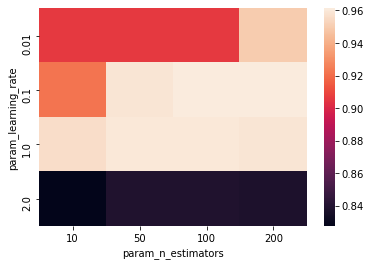

In [30]:
print("Best cross-validation score: {:.2f}".format(gs_results.best_score_))
print("Best parameters: ", gs_results.best_params_)

import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='mean_test_score', index='param_learning_rate', columns='param_n_estimators')

pvt
ax = sns.heatmap(pvt)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

In [31]:
gbc_model = GradientBoostingClassifier(learning_rate=gs_results.best_params_["learning_rate"], n_estimators=gs_results.best_params_["n_estimators"])
gbc_model.fit(X_train,y_train)

GradientBoostingClassifier()

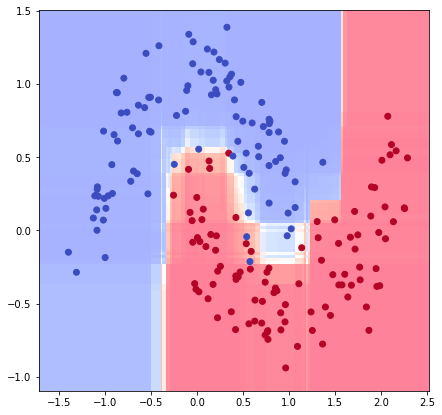

In [32]:
plot_decision_boundaries(X_test[:,0],X_test[:,1],y_test,gbc_model)

In [33]:
y_pred = gbc_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(acc))

Accuracy: 0.97


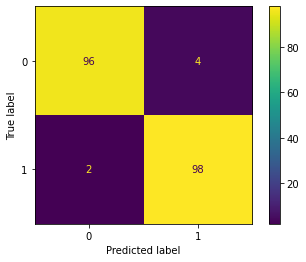

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

Muy similar al caso anterior tanto en resultados de matriz de confusión, accuracy y frontera. Comentar que en este caso las zonas pertenecientes a las esquinas superior derecha e inferior izquierda no son zonas de indecisión y el modelo tiene bastante claro en qué luna clasificar los puntos.

# 2. Implementación de un caso práctico (5 puntos)

Ahora que ya entendemos cómo funcionan algunos modelos, vamos a aplicarlos a un caso práctico. La primera mitad de la práctica se ha realizado utilizando una variable objetivo categórica, para esta segunda mitad emplearemos una variable objetivo numérica. Es decir, trabajaremos con un problema de regresión, no de clasificación.

Utilizaremos un conjunto de datos público de precios de viviendas en Taiwán con el objetivo de encontrar las mejores ofertas del mercado. La descripción completa del conjunto de datos la podemos encontrar en el siguiente enlace: https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

Comencemos cargando los datos en un DataFrame de pandas:

In [35]:
dataset = pd.read_excel('Real estate valuation data set.xlsx', engine='openpyxl')

dataset.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


La primera columna ("*No*") es el identificador numérico de la muestra. Las columnes "*Xn ...*" son los diferentes atributos descriptivos. Finalmente, la columna "*Y ...*" es el valor objetivo o precio de la vivienda.

Extraemos del *DataFrame* la variable objetivo y los atributos descriptivos que utilizaremos posteriormente en el modelo predictivo:

In [36]:
X = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]]

y = dataset['Y house price of unit area']

### 2.1. Análisis descriptivo
Cuando se nos proporciona un dataset, antes de comenzar a hacer nada, es muy importante hacer un análisis exploratorio para conocer los datos con los que trabajaremos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> analizar gráficamente la distribución de todas las variables (features y target). Recuerda que las variables categóricass se representan con gráficas de barras, mientras que las numéricas se representan con histogramas.
</div>

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


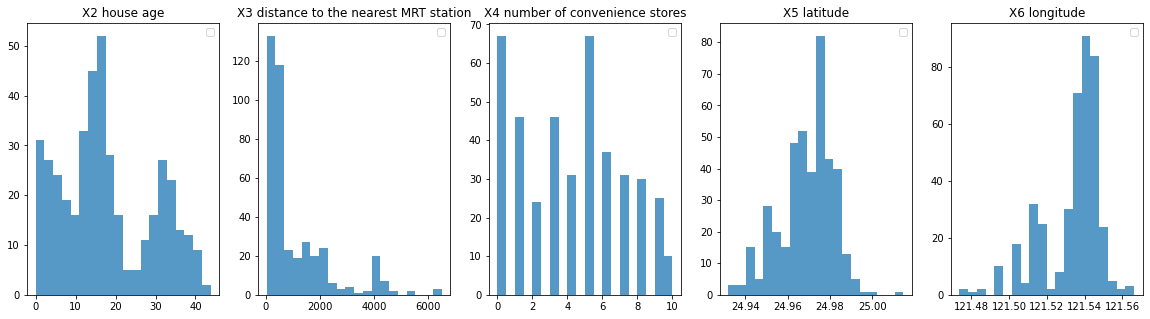

In [37]:
#1- Creo la figura constituida en 5 subplots
figure, axis = plt.subplots(nrows = 1, ncols = 5, figsize = (20,5))

# Por cada medición, creo un eje
for i, feat in enumerate(X):
        axis[i].hist(X.loc[:,feat],
                     alpha = 0.75, bins = 20)
        axis[i].set_title(feat)
        axis[i].legend(loc = 0)

### 2.2. Preprocesamiento de los datos

Una vez hecho un primer análisis, se trata de "limpiar" el dataset (las features) y adaptarlo a nuestras necesidades (en este caso, predecir el precio de una vivienda).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> comprueba si hay valores nulos. En caso de haberlos, elimina las filas correspondientes.
</div>

In [38]:
X[X.isnull()].count()

X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
dtype: int64

El siguiente paso sería estudiar la correlación entre todas las variables descriptivas (features) numéricas. Esto se hace para asegurarse de que no hay dos variables muy relacionadas entre sí, ya que en tal caso sería conveniente seleccionar una de las dos o combinarlas en una nueva para reducir dimensionalidad.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> muestra la correlación entre todas las features numéricas. Si hay dos con una correlación superior al 90%, elimina una de ellas.
    
Puedes utilizar heatmap, de seaborn, para verlas en un mapa de colores.
</div>

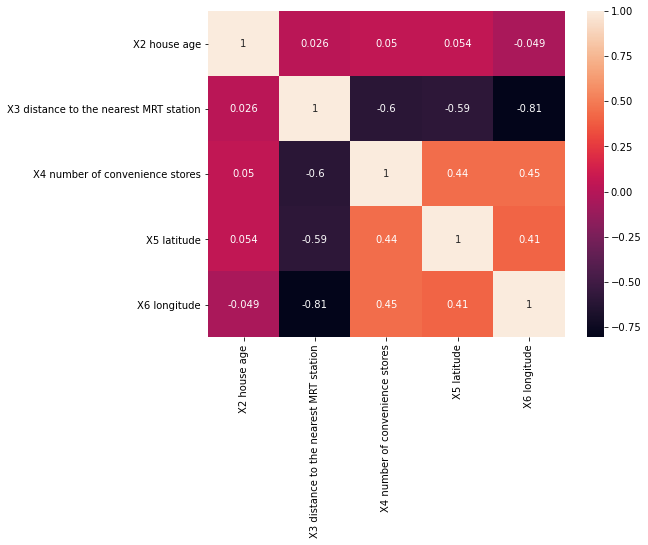

In [39]:
corr_df = X.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

#Observamos que no hay dos variables con una correlación superior al 90%

Ya tenemos las variables finales con las que trabajaremos. Vamos a observar ahora cuál es la relación de cada una de ellas con el target.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> realiza varios scatterplots cruzando los diferentes atributos descriptivos con la variable target. Se ha de realizar un scatterplot por atributo.
</div>

In [40]:
min_=X["X3 distance to the nearest MRT station"].min()
max_ = X["X3 distance to the nearest MRT station"].max()
dif = max_-min_
print(max_,dif)
np.arange(min_, max_+dif/5, (max_-min_)/5)

6488.021 6464.6381599999995


array([  23.38284 , 1316.310472, 2609.238104, 3902.165736, 5195.093368,
       6488.021   ])

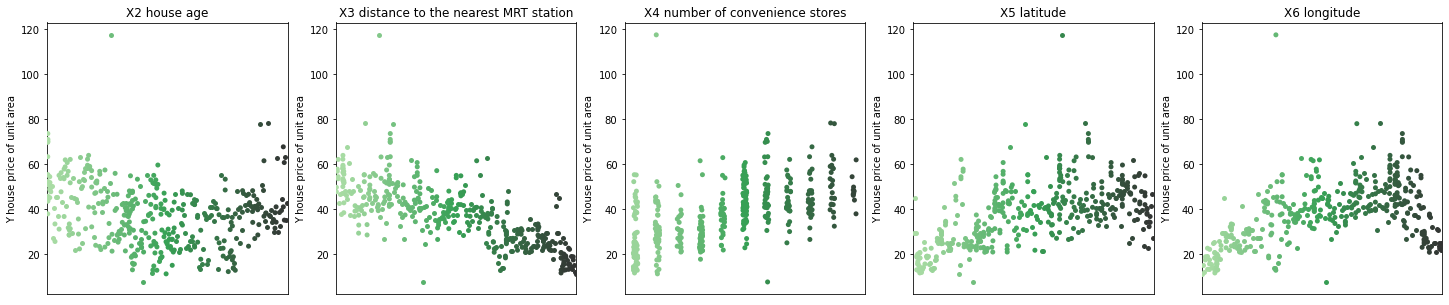

In [41]:
figure, axis = plt.subplots(nrows = 1, ncols = 5, figsize = (25,5))

# Por cada medición, creo un eje
for i, feat in enumerate(X):
        sns.stripplot(ax=axis[i],x=feat,
                  y="Y house price of unit area",
                  data=dataset, palette="Greens_d")
        axis[i].set_title(feat)
        axis[i].xaxis.set_visible(False)



<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué atributos tienen correlación positiva? ¿Cuáles negativa? ¿Cuáles no tienen ninguna correlación? Analiza cada uno de los gráficos. ¿Tiene sentido que la relación de cada atributo con el target sea la encontrada?
</div>

Analicemos cada variable:
- La variable X2 no detectamos correlación. Esto tiene sentido ya que la casa puede ser antigua, pero estar en un barrio muy valorado. Por ejemplo, Malasaña en Madrid.
- Podemos ver que la variable X3 tienen una correlación negativa. Cosa perfectamente comprensible. Las viviendas cercanas a estaciones, estarán mejor valoradas.
- La variable X4 tiene cierta correlación positiva. Cosa que tiene sentido cierto sentido ya que si el piso esta en una zona comercial, tendrá mayor valor, pero tampoco es una correlación muy fuerte, ya que puede darse el caso de que la zona no sea tan comercial pero tenga otras ventajas, como cerca de colegios, universidades, estaciones de metro, etc.
- La otras dos variables no tienen correlacióin apreciable. Puede que haya ciertas zonas mejor valoradas, como la zona del centro - noreste, pero no hay demasiada dispersión en los datos.

### 2.3. Entrenamiento de un modelo

Ahora que ya tenemos el dataset limpio y hemos hecho un análisis de las diferentes variables, podemos proceder a entrenar un modelo para predecir el precio de una vivienda. Probaremos con 2 modelos diferentes e interpretaremos sus resultados. Para comenzar, separemos el dataset en train y test.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> divide el <i>dataset</i> en dos subconjuntos, <i>train</i> (80% de los datos) y <i>test</i> (20% restante). Nombraremos los conjuntos: X_train, X_test, y_train e y_test. Utilizaremos la opción random_state=24.
    
Puedes servirte de la implementación <i>train_test_split</i> de <i>sklearn</i>.
</div>

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=24)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> utiliza un árbol de decisión simple con max_depth=5 para modelar el dataset sobre el conjunto de train. Dibuja el árbol de decisión. Si te queda muy grande, dibuja un árbol entrenado con menor profundidad para que puedas apreciarlo mejor. Utiliza alguna medida de error (puedes escoger la que quieras: MAE, RMSE, ...) para estimar cómo de bien lo ha hecho el modelo prediciedo en train y en test. También servirá para poder comparar a posteriori con otro modelo.
    
Para dibujar el árbol puedes guiarte con este enlace: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc. Towardsdatascience es un blog que te deja leer unos cuantos artículos gratuitamente y despues te pide subscripción. Si fuera el caso y ya hubieras llegado al límite, puedes abrir el enlace en una pestaña de navegación privada.
</div>

In [43]:
dtr_model = DecisionTreeRegressor(max_depth = 5, 
                             random_state = 24)

In [44]:
dtr_model.fit(X_train, y_train)

y_pred = dtr_model.predict(X_test)


[Text(465.0, 792.75, 'X[1] <= 981.578\nmse = 187.108\nsamples = 331\nvalue = 38.008'),
 Text(232.5, 566.25, 'X[0] <= 11.7\nmse = 118.588\nsamples = 222\nvalue = 44.652'),
 Text(116.25, 339.75, 'X[0] <= 10.65\nmse = 121.036\nsamples = 69\nvalue = 52.049'),
 Text(58.125, 113.25, '\n  (...)  \n'),
 Text(174.375, 113.25, '\n  (...)  \n'),
 Text(348.75, 339.75, 'X[1] <= 331.727\nmse = 81.675\nsamples = 153\nvalue = 41.316'),
 Text(290.625, 113.25, '\n  (...)  \n'),
 Text(406.875, 113.25, '\n  (...)  \n'),
 Text(697.5, 566.25, 'X[4] <= 121.509\nmse = 53.701\nsamples = 109\nvalue = 24.478'),
 Text(581.25, 339.75, 'X[1] <= 4007.266\nmse = 16.495\nsamples = 29\nvalue = 17.431'),
 Text(523.125, 113.25, '\n  (...)  \n'),
 Text(639.375, 113.25, '\n  (...)  \n'),
 Text(813.75, 339.75, 'X[3] <= 24.984\nmse = 42.661\nsamples = 80\nvalue = 27.032'),
 Text(755.625, 113.25, '\n  (...)  \n'),
 Text(871.875, 113.25, '\n  (...)  \n')]

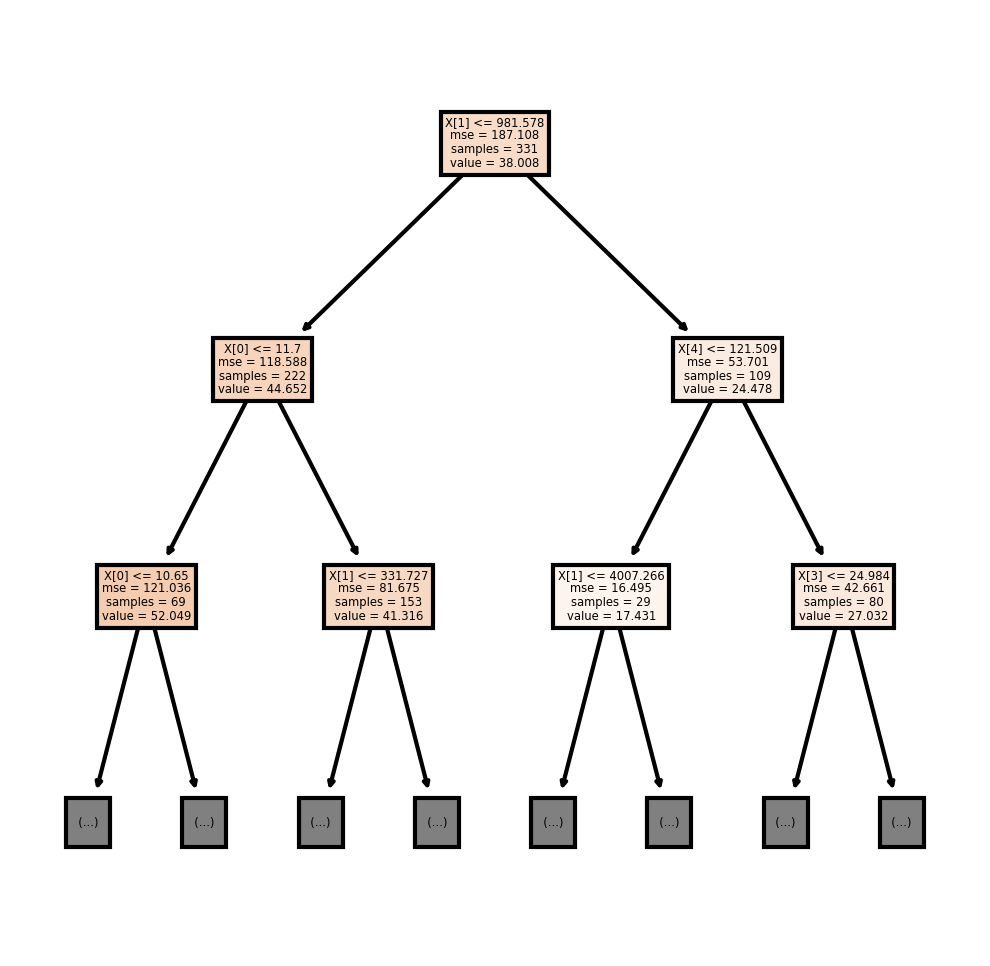

In [45]:
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)


tree.plot_tree(dtr_model, filled = True, max_depth=2)

In [46]:
rmse = np.sqrt(((y_pred - y_test) ** 2).mean())

print("rmse error is: {:.2f}".format(rmse))

rmse error is: 6.88


<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta el árbol de decisión, ¿qué variables son las que han tenido más peso? ¿Has obtenido una buena precisión evaluando en test? ¿Se ha producido overfitting?
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> utiliza Random Forest o Gradient Boosting para modelar el dataset. Esta vez vamos a optimizar el modelo para obtener los mejores resultados posibles. Tal y como hemos visto anteriormente, recuerda seguir los siguientes pasos:
    
  - Utilizar el dataset de train para encontrar los mejores hiperparámetros haciendo cross-validation.
  - Entrenar el modelo con train, predecir con train y test y calcular el error (MAE, RMSE, ...)
</div>

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {'learning_rate': [0.01, 0.1, 1, 2],
              'n_estimators': [10, 50, 100, 200]}

gs = GridSearchCV(GradientBoostingRegressor(), param_grid,cv=4)

gs_results = gs.fit(X_train, y_train)

Best cross-validation score: 0.69
Best parameters:  {'learning_rate': 0.1, 'n_estimators': 50}


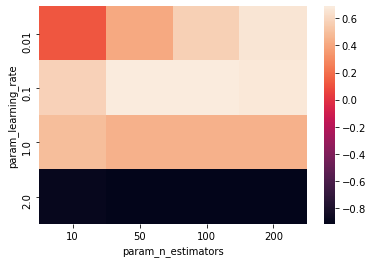

In [51]:
print("Best cross-validation score: {:.2f}".format(gs_results.best_score_))
print("Best parameters: ", gs_results.best_params_)

import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='mean_test_score', index='param_learning_rate', columns='param_n_estimators')

pvt
ax = sns.heatmap(pvt)

In [56]:
gbr_model = GradientBoostingRegressor(learning_rate=gs_results.best_params_["learning_rate"], n_estimators=gs_results.best_params_["n_estimators"])
gbr_model.fit(X_train,y_train)

GradientBoostingRegressor(n_estimators=50)

In [57]:
y_pred = gbr_model.predict(X_test)

rmse = np.sqrt(((y_pred - y_test) ** 2).mean())

print("rmse error is: {:.2f}".format(rmse))

rmse error is: 5.86


Un Random Forest / Gradient Boosting no es tan fácil de interpretar como un simple Decision Tree. No podemos dibujar un árbol porque son combinaciones de muchos árboles, pero sí que podemos saber cuáles han sido las variables más decisivas a la hora de generar el modelo. Para saberlo, no podremos hacerlo mirando cómo se divide el árbol, sino que se lo tendremos que consultar al modelo através de la "feature importance" de éste.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> muestra cada variable del modelo aprendido junto con su feature importance.
</div>

In [59]:
gbr_model.feature_importances_

array([0.22367508, 0.60955793, 0.01147349, 0.11714146, 0.03815204])

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta el clasificador, ¿cuáles son las variables que han tenido más peso? ¿Has obtenido una buena precisión evaluando en test? ¿Se ha producido overfitting?
</div>

### 2.4. Predicción de casos nuevos

Hasta ahora hemos entrenado un modelo y hemos evaluado en test para hacernos una idea de la precisión de nuestro modelo con datos reales. Ahora vamos a utilizarlo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 
    
  - Caso 1: queremos comprar una vivienda que está situada a 1km de la estación de tren, concretamente sus coordenadas son: 24.87745, 121.31683. La vivienda tiene 3 tiendas cerca y se construyó hace 15 años. Se vende por 24500€/m2 y queremos saber si está por encima o por debajo del precio de mercado.	
    
  - Caso 2: somos una empresa que se dedica a hacer negocio comprando pisos baratos, arreglándolos y volviéndolos a vender más caros. Queremos saber qué viviendas del conjunto de datos se venden por debajo de su precio de mercado ("chollos") para poder comprarlas y revenderlas en un futuro.
</div>